***
# Lab 2 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***

# Data Preparation
***

In [22]:
#import packages
import pandas as pd
import numpy as np
import lightgbm as lgb

import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier,LogisticRegressionCV
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import time
import warnings


#allen Packages
#import catboost as ctb
#from catboost import CatBoostClassifier

In [23]:
df = pd.read_csv(r'/Users/brittanylewandowski/Desktop/airline_merged.csv',low_memory=False)

In [24]:
pd.set_option('display.max_columns', None)

In [25]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

In [26]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [27]:
#looking at dataframe after removing highly correlated fields.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 37 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   year                   int64  
 1   month                  int64  
 2   day                    int64  
 3   day_of_week            int64  
 4   airline_cd             object 
 5   airline_name           object 
 6   flight_number          int64  
 7   tail_number            object 
 8   origin_airport         object 
 9   airport_origin         object 
 10  city_origin            object 
 11  state_origin           object 
 12  country_origin         object 
 13  latitude_origin        float64
 14  longitude_origin       float64
 15  destination_airport    object 
 16  airport_destination    object 
 17  city_destination       object 
 18  state_destination      object 
 19  country_destination    object 
 20  latitude_destination   float64
 21  longitude_destination  float64
 22  scheduled_departur

In [28]:
#selecting subset of data set
airports = ['BHM']

In [29]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [30]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [31]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [32]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_departure_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
df_air.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12514 non-null  int64  
 1   month                  12514 non-null  int64  
 2   day                    12514 non-null  int64  
 3   day_of_week            12514 non-null  int64  
 4   airline_cd             12514 non-null  object 
 5   airline_name           12514 non-null  object 
 6   flight_number          12514 non-null  int64  
 7   tail_number            12510 non-null  object 
 8   origin_airport         12514 non-null  object 
 9   airport_origin         12514 non-null  object 
 10  city_origin            12514 non-null  object 
 11  state_origin           12514 non-null  object 
 12  country_origin         12514 non-null  object 
 13  latitude_origin        12514 non-null  float64
 14  longitude_origin       12514 non-null  float64
 15

In [35]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [36]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

In [37]:
#Splitting features and response for Task 1: is_departure_delay:
target_delay_cols = ['is_departure_delay','departure_delay']
feature_delay_cols = final_df.loc[:, ~final_df.columns.isin(target_delay_cols)].columns
X_delay = final_df[feature_delay_cols] # Features
y_delay = final_df.is_departure_delay # Target variable

In [38]:
#Splitting features and response for Task 2: Cancellation:
target_cancel_cols = ['cancelled','cancellation_reason']
feature_cancel_cols = final_df.loc[:, ~final_df.columns.isin(target_cancel_cols)].columns
X_cancel = final_df[feature_cancel_cols] # Features
y_cancel = final_df.cancelled # Target variable

In [39]:
#split original dataset into features and target variable
X_delay_train,X_delay_test,y_delay_train,y_delay_test=train_test_split(X_delay,y_delay,test_size=0.20,random_state=0)

In [40]:
#split original dataset into features and target variable
X_cancel_train,X_cancel_test,y_cancel_train,y_cancel_test=train_test_split(X_cancel,y_cancel,test_size=0.20,random_state=0)

In [41]:
#imputing 0 into NaN values for logistic regression after OHE
X_cancel_train = X_cancel_train.fillna(0)
X_cancel_test = X_cancel_test.fillna(0)
y_cancel_train = y_cancel_train.fillna(0)
y_cancel_test = y_cancel_test.fillna(0)

In [42]:
#imputing 0 into NaN values for logistic regression after OHE
X_delay_train = X_delay_train.fillna(0)
X_delay_test = X_delay_test.fillna(0)
y_delay_train = y_delay_train.fillna(0)
y_delay_test = y_delay_test.fillna(0)

In [43]:
#checking shape of data for Task 2:
print('X_cancel_train shape: ',X_cancel_train.shape,'\n')
print('X_cancel_test shape: ',X_cancel_test.shape,'\n')
print('y_cancel_train shape: ',y_cancel_train.shape,'\n')
print('y_cancel_test shape: ',y_cancel_test.shape)

X_cancel_train shape:  (10011, 1776) 

X_cancel_test shape:  (2503, 1776) 

y_cancel_train shape:  (10011,) 

y_cancel_test shape:  (2503,)


In [44]:
#checking shape of data for Task 1:
print('X_delay_train shape: ',X_delay_train.shape,'\n')
print('X_delay_test shape: ',X_delay_test.shape,'\n')
print('y_delay_train shape: ',y_delay_train.shape,'\n')
print('y_delay_test shape: ',y_delay_test.shape)

X_delay_train shape:  (10011, 1775) 

X_delay_test shape:  (2503, 1775) 

y_delay_train shape:  (10011,) 

y_delay_test shape:  (2503,)


***
# Modeling and Evaluation
***

### LGBM:
***

In [19]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a
#https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective

# Define a pipeline to search for the best combination of PCA truncation

pca_lgbm = PCA(n_components = .95,
               svd_solver = 'auto')


In [20]:
# Define a Standard Scaler to normalize inputs

scaler_lgbm = RobustScaler()

lr = 0.15
boost = 'dart' #'gbdt' 
obj = 'binary'
tl = 'voting' # 'data'
numiter = 1000
mbin = 300
nleaves = 42


In [21]:
# Scale -> PCA -> LR 
lgbm = lgb.LGBMClassifier(learning_rate = lr,
                          boosting = boost,
                          objective = obj,
                          tree_learner = tl,
                          #num_iterations = numiter,
                          num_leaves = nleaves,
                          max_bin = mbin,
                          extra_trees = True)


In [22]:
%%time
#start_lgbm = time.time()
pipe_lgbm = Pipeline(steps=[("scaler", scaler_lgbm),
                       ("pca", pca_lgbm),
                       ("LightGBM", lgbm)])

pipe_lgbm.fit(X_train,y_train)
#end_lgbm = time.time()

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
CPU times: user 23.8 s, sys: 3.74 s, total: 27.6 s
Wall time: 4.6 s


Pipeline(steps=[('scaler', RobustScaler()), ('pca', PCA(n_components=0.95)),
                ('LightGBM',
                 LGBMClassifier(boosting='dart', extra_trees=True,
                                learning_rate=0.15, max_bin=300, num_leaves=42,
                                objective='binary', tree_learner='voting'))])

In [23]:
#predict
y_pred_lgbm=pipe_lgbm.predict(X_test)

In [24]:
accuracy_lgbm = metrics.accuracy_score(y_test,y_pred_lgbm)
precision_lgbm = metrics.precision_score(y_test, y_pred_lgbm)
recall_lgbm = metrics.recall_score(y_test, y_pred_lgbm)

In [25]:
#print results 
print('____________Start LightGBM Base Model Results______________:')
print('Accuracy:\n',accuracy_lgbm,'\n')
print('Precision:\n',recall_lgbm,'\n')
print('Recall:\n',recall_lgbm,'\n')
print('____________End LightGBM Base Model Results________________')

____________Start LightGBM Base Model Results______________:
Accuracy:
 0.8286056731921694 

Precision:
 0.4732824427480916 

Recall:
 0.4732824427480916 

____________End LightGBM Base Model Results________________


***
## Random Forest:
***

In [45]:
#Importing required libraries.
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
#Specififying Stratified Kfold for cv.
skfcv = StratifiedKFold(n_splits=10)

In [47]:
#Creating our random forest pipeline.
rf = RandomForestClassifier(random_state=0)

In [51]:
#Fitting random forest model on training data.
rf.fit(X_delay_train, y_delay_train)

RandomForestClassifier(random_state=0)

In [52]:
#Predicting on our test set.
y_pred_rf = rf.predict(X_delay_test)

In [53]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score = cross_val_score(rf, X_delay_test, y_delay_test, cv=3, scoring='accuracy')


In [55]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1660   57]
 [ 330  456]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1717
           1       0.89      0.58      0.70       786

    accuracy                           0.85      2503
   macro avg       0.86      0.77      0.80      2503
weighted avg       0.85      0.85      0.83      2503

=== All AUC Scores ===
[0.82994012 0.83453237 0.81534772]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8266067385612468


### Grid Search for Task One:

In [72]:
#Task 1 Grid Search parameters: 
#Specifying the number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#Specifying criterion for each split:
criterion = ['gini','entropy']
#Specifying the number of features to consider at every split:
max_features = ['auto','sqrt', 'log2','none']

In [73]:
#Creating pipeline for GridSearch:
#Creating and printing my random grid with parameters defined above:
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features}
print(param_grid)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', 'none']}


In [74]:
#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)

In [75]:
#Throwing RF through a GridSearch:
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=1)

In [77]:
#Fiting the random search model on our training data:
rf_random.fit(X_delay_train, y_delay_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/s

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', 'none'],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             verbose=1)

In [78]:
#Viewing the best parameters selected from GridSearch:
rf_random.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}

### Re-Fitting RF With GridSearch Parameters:

In [ ]:
#Defining RF model with best parameters from GridSearch:
rf_gs = RandomForestClassifier(criterion='entropy',max_features='auto',n_estimators=100,random_state=0) #INSERT IN BEST GRIDSEARCH PARAMS

In [146]:
#Re-fitting RF model with GS parameters and SKFCV on training data:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_train = cross_val_score(rf_gs, X_delay_train, y_delay_train, cv=skfcv, scoring='accuracy')

In [134]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score_train)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_train.mean())

=== Confusion Matrix ===
[[1717    0]
 [ 742   44]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1717
           1       1.00      0.06      0.11       786

    accuracy                           0.70      2503
   macro avg       0.85      0.53      0.46      2503
weighted avg       0.79      0.70      0.60      2503

=== All AUC Scores ===
[0.83133733 0.83816184 0.84315684 0.84215784 0.83716284 0.83116883
 0.84515485 0.82817183 0.81718282 0.83616384]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8349818843830821


### Fitting RF GridSearch on test data: 

In [135]:
#Re-fitting RF model with GS parameters and SKFCV:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_test = cross_val_score(rf_gs, X_delay_test, y_delay_test, cv=skfcv, scoring='accuracy')

In [136]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score_test)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_test.mean())

=== Confusion Matrix ===
[[1717    0]
 [ 742   44]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1717
           1       1.00      0.06      0.11       786

    accuracy                           0.70      2503
   macro avg       0.85      0.53      0.46      2503
weighted avg       0.79      0.70      0.60      2503

=== All AUC Scores ===
[0.82868526 0.83665339 0.83665339 0.84       0.864      0.852
 0.808      0.824      0.808      0.836     ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.833399203187251


In [137]:
#Comparing Mean AUC Score of train and test GridSearch RF models:
print("Mean AUC Score - Random Forest: ", rfc_cv_score_train.mean())
print("Mean AUC Score - Random Forest: ", rfc_cv_score_test.mean())

Mean AUC Score - Random Forest:  0.8349818843830821
Mean AUC Score - Random Forest:  0.833399203187251


### Feature Importances from training data on task one GridSearch RF Model:

In [210]:
#Fiting the random search model on our training data:
rf_gs.fit(X_delay_train, y_delay_train)
importances = rf_gs.feature_importances_

In [138]:
# Getting indices of N = 3 maximum values
x = np.argsort(importances)[::-1][:5]
print("Indices:",x)

# Getting N maximum values
print("Values:",importances[x])

Indices: [12 20  2 10 13]
Values: [0.14371487 0.08693868 0.08564488 0.08370328 0.08020031]


<AxesSubplot:title={'center':'RF Train Data Feature Importances'}>

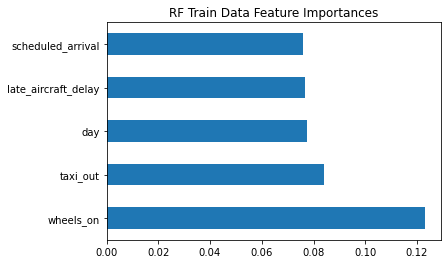

In [169]:
plt.title('RF Train Data Feature Importances')
(pd.Series(rf_gs.feature_importances_, index=X_delay.columns)
   .nlargest(5)
   .plot(kind='barh')) 

### Feature Importances from test data on task one Gridsearch RF Model:

In [180]:
#Defining RF model with best parameters from GridSearch:
rf_gs_test = RandomForestClassifier(criterion='entropy',max_features='auto',n_estimators=100,random_state=0) #INSERT IN BEST GRIDSEARCH PARAMS

In [181]:
#Fiting the random search model on our training data:
rf_gs_test.fit(X_delay_test, y_delay_test)
importances = rf_gs.feature_importances_

In [182]:
# Getting indices of N = 3 maximum values
x = np.argsort(importances)[::-1][:5]
print("Indices:",x)

# Getting N maximum values
print("Values:",importances[x])

Indices: [12 10  2 20 14]
Values: [0.12326567 0.08422274 0.07745542 0.07651711 0.07591451]


<AxesSubplot:title={'center':'RF Test Data Feature Importances'}>

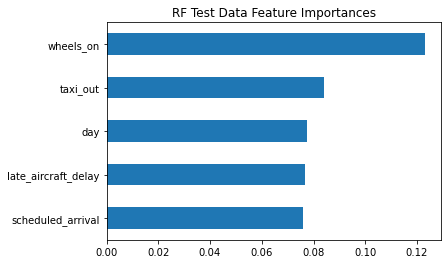

In [206]:
plt.title('RF Test Data Feature Importances')
(pd.Series(rf_gs_test.feature_importances_, index=X_delay.columns)
   .nlargest(5)
   .nsmallest(5)  
.plot(kind='barh'))

### Visualizing task one RF GridSearch Model:

[Text(0.18710879255715707, 0.9827586206896551, 'X[21] <= 1.0\nentropy = 0.906\nsamples = 1558\nvalue = [1699, 804]'),
 Text(0.18483671076221245, 0.9482758620689655, 'X[11] <= 64.5\nentropy = 0.897\nsamples = 1542\nvalue = [1699, 775]'),
 Text(0.032874183470604945, 0.9137931034482759, 'X[20] <= 3.0\nentropy = 0.614\nsamples = 153\nvalue = [207, 37]'),
 Text(0.030602101675660322, 0.8793103448275862, 'X[13] <= 15.5\nentropy = 0.587\nsamples = 151\nvalue = [207, 34]'),
 Text(0.028330019880715707, 0.8448275862068966, 'X[10] <= 11.5\nentropy = 0.603\nsamples = 146\nvalue = [197, 34]'),
 Text(0.015904572564612324, 0.8103448275862069, 'X[12] <= 1911.0\nentropy = 0.404\nsamples = 47\nvalue = [80, 7]'),
 Text(0.013632490769667709, 0.7758620689655172, 'X[13] <= 6.5\nentropy = 0.365\nsamples = 46\nvalue = [80, 6]'),
 Text(0.01136040897472309, 0.7413793103448276, 'X[9] <= 955.0\nentropy = 0.592\nsamples = 23\nvalue = [36, 6]'),
 Text(0.009088327179778472, 0.7068965517241379, 'X[3] <= 1.5\nentropy =

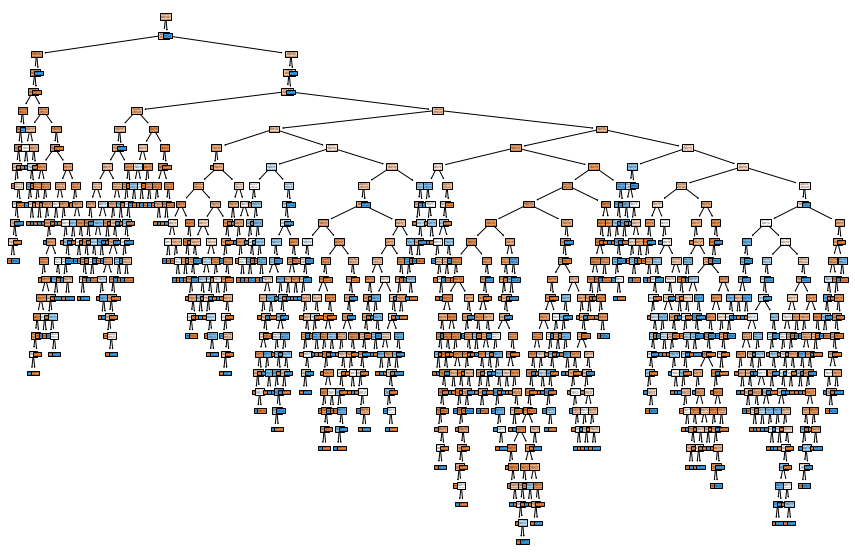

In [178]:
from sklearn import tree

plt.figure(figsize=(15,10))
tree.plot_tree(rf_gs.estimators_[2],filled=True)

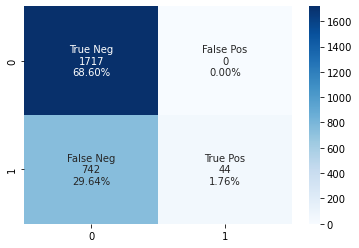

In [200]:
basic_cf_matrix = confusion_matrix(y_delay_test, y_pred_rf)


basic_group_names = ['True Neg','False Pos','False Neg','True Pos']

basic_group_counts = ["{0:0.0f}".format(value) for value in
                basic_cf_matrix.flatten()]

basic_group_percentages = ["{0:.2%}".format(value) for value in
                     basic_cf_matrix.flatten()/np.sum(basic_cf_matrix)]

basic_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(basic_group_names,basic_group_counts,basic_group_percentages)]

basic_labels = np.asarray(basic_labels).reshape(2,2)

sns.heatmap(basic_cf_matrix, annot=basic_labels, fmt='', cmap='Blues');

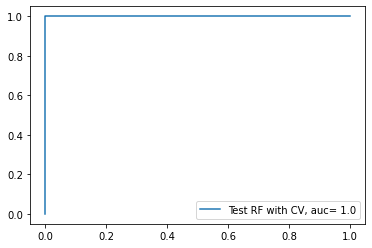

In [203]:
#ROC Curve
basic_ypred_proba = rf_gs_test.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  basic_ypred_proba)
basic_lr_auc = metrics.roc_auc_score(y_delay_test, basic_ypred_proba)
plt.plot(fpr,tpr,label="Test RF with CV, auc= "+str(round(basic_lr_auc,5)))
plt.legend(loc=0)
plt.show();

### T-Test:

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=rf_gs,
                          estimator2=rf_gs_test,
                          X=X_delay, y=y_delay,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

### TASK TWO Base RF (Cancellations):

In [85]:
#Creating our random forest pipeline.
rf = RandomForestClassifier(random_state=0)

In [86]:
#Fitting random forest model on training data.
rf.fit(X_cancel_train, y_cancel_train)

RandomForestClassifier(random_state=0)

In [87]:
#Predicting on our test set.
y_pred_rf = rf.predict(X_cancel_test)

In [88]:
#Running RF model through CV:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score2 = cross_val_score(rf, X_cancel_test, y_cancel_test, cv=skfcv, scoring='accuracy')

In [89]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score2)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score2.mean())

=== Confusion Matrix ===
[[2459    0]
 [   0   44]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2459
           1       1.00      1.00      1.00        44

    accuracy                           1.00      2503
   macro avg       1.00      1.00      1.00      2503
weighted avg       1.00      1.00      1.00      2503

=== All AUC Scores ===
[1.    1.    1.    1.    1.    1.    1.    1.    0.996 1.   ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9996


### TASK TWO: RF Grid Search: 

In [121]:
#Creating pipeline for GridSearch:
#Creating and printing my random grid with parameters defined above:
param_grid2 = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features}
print(param_grid2)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', 'none']}


In [ ]:
#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)

In [122]:
#Throwing RF through a GridSearch:
rf_random2 = GridSearchCV(estimator = rf, param_grid = param_grid2, cv = 3, verbose=1)

In [123]:
#Fiting the random search model on our training data:
rf_random2.fit(X_cancel_train, y_cancel_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/s

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', 'none'],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             verbose=1)

In [124]:
#Viewing the best parameters selected from GridSearch:
rf_random2.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 144}

### TASK TWO: Re-Fitting RF With GridSearch Parameters:

In [125]:
#Defining RF model with best parameters from GridSearch:
rf_gs2 = RandomForestClassifier(criterion='gini',max_features='auto',n_estimators=144,random_state=0) #INSERT IN BEST GRIDSEARCH PARAMS

In [127]:
#Re-fitting RF model with GS parameters and SKFCV:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_train_2 = cross_val_score(rf_gs2, X_cancel_train, y_cancel_train, cv=skfcv, scoring='accuracy')

In [128]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score_train_2)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_train_2.mean())

=== Confusion Matrix ===
[[1717    0]
 [ 742   44]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1717
           1       1.00      0.06      0.11       786

    accuracy                           0.70      2503
   macro avg       0.85      0.53      0.46      2503
weighted avg       0.79      0.70      0.60      2503

=== All AUC Scores ===
[1.       0.999001 1.       0.999001 1.       1.       1.       1.
 1.       1.      ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9998001998001997


### Fitting GridSearch model on test set:

In [129]:
#Re-fitting RF model with GS parameters and SKFCV:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_test_2 = cross_val_score(rf_gs2, X_cancel_test, y_cancel_test, cv=skfcv, scoring='accuracy')

In [130]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score_test_2)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_test_2.mean())

=== Confusion Matrix ===
[[1717    0]
 [ 742   44]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1717
           1       1.00      0.06      0.11       786

    accuracy                           0.70      2503
   macro avg       0.85      0.53      0.46      2503
weighted avg       0.79      0.70      0.60      2503

=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


In [131]:
#Comparing Mean AUC Score between train and test GridSearch RF models:
print("Mean Train AUC Score - Random Forest: ", rfc_cv_score_train_2.mean())
print("Mean Test AUC Score - Random Forest: ", rfc_cv_score_test_2.mean())

Mean Train AUC Score - Random Forest:  0.9998001998001997
Mean Test AUC Score - Random Forest:  1.0


### TASK TWO Train Data Feature Importance:

In [160]:
#Fiting the random search model on our training data:
rf_gs2.fit(X_cancel_train, y_cancel_train)
importances2 = rf_gs2.feature_importances_

In [161]:
#Getting indices of N=5 maximum values:
x=np.argsort(importances2)[::-1][:5]
print("Indices:",x)


#Getting 5 maximum values:
print("Values:", importances2[x])

Indices: [14 13 11 10 22]
Values: [0.29688933 0.26809445 0.26143363 0.06147337 0.01596824]


<AxesSubplot:title={'center':'RF Train Data Feature Importances'}>

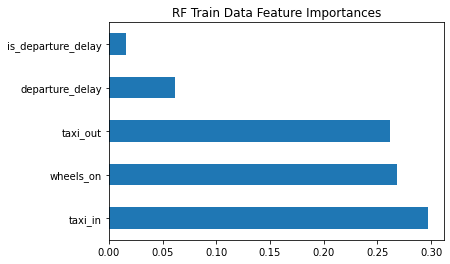

In [170]:
plt.title('RF Train Data Feature Importances')
(pd.Series(rf_gs2.feature_importances_, index=X_cancel.columns)
   .nlargest(5)
.plot(kind='barh'))

### TASK TWO Test Data Feature Importance:

In [157]:
#Fiting the random search model on our test data:
rf_gs2.fit(X_cancel_test, y_cancel_test)
importances2 = rf_gs2.feature_importances_

In [158]:
#Getting indices of N=5 maximum values:
x=np.argsort(importances2)[::-1][:5]
print("Indices:",x)


#Getting 5 maximum values:
print("Values:", importances2[x])

Indices: [13 11 14 10 22]
Values: [0.27401716 0.24506865 0.24468243 0.06456274 0.02360699]


<AxesSubplot:title={'center':'RF Test Data Feature Importances'}>

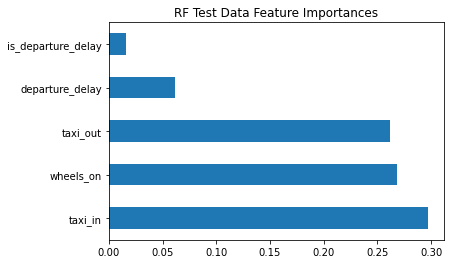

In [171]:
plt.title('RF Test Data Feature Importances')
(pd.Series(rf_gs2.feature_importances_, index=X_cancel.columns)
   .nlargest(5)
.plot(kind='barh'))

# Gridsearch

In [71]:
#Specifying the number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#Specifying criterion for each split:
criterion = ['gini','entropy']
#Specifying the maximum number of levels in the tree:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]The 
max_depth.append(None)
#Specifying the number of features to consider at every split:
max_features = ['auto','sqrt', 'log2','none']
#Specifying the minimum number of samples required to split a node:
min_samples_split = [2, 5, 10]
#Specifying the minimum number of samples required at each leaf node:
min_samples_leaf = [1, 2, 4]
#Specifying the method of selecting samples for training each tree:
bootstrap = [True, False]
#Creating and printing my random grid with parameters defined above:


verbo = [1]
param_grid= {'n_estimators': n_estimators,
               'criterion': criterion,
               'verbose': verbo,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
            }

print(param_grid)

#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
#Fiting the random search model on our training data:
rf_random.fit(X_delay_train, y_delay_train)
print(rf_random.best_estimator_)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'criterion': ['gini', 'entropy'], 'verbose': [1], 'max_features': ['auto', 'sqrt', 'log2', 'none'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

KeyboardInterrupt: 

In [38]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_split=5,
                       random_state=0)


In [62]:
#Specifying the number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#Specifying criterion for each split:
criterion = ['gini','entropy','log_loss']
#Specifying the maximum number of levels in the tree:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Specifying the number of features to consider at every split:
max_features = ['auto','sqrt', 'log2','none']
#Specifying the minimum number of samples required to split a node:
min_samples_split = [2, 5, 10]
#Specifying the minimum number of samples required at each leaf node:
min_samples_leaf = [1, 2, 4]
#Specifying the method of selecting samples for training each tree:
bootstrap = [True, False]
#Creating and printing my random grid with parameters defined above:

In [63]:
param_grid= {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
            }

print(param_grid)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['auto', 'sqrt', 'log2', 'none']}


In [64]:
#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)

In [65]:
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=1)

In [66]:
#Fiting the random search model on our training data:
rf_random.fit(X_delay_train, y_delay_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/Users/brittanylewandowski/opt/anaconda3/envs/ML1/lib/python3.7/

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['auto', 'sqrt', 'log2', 'none'],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             verbose=1)

In [67]:
rf_random.best_estimator_

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
#Final RF model Task One:
final_rf1 = RandomForestClassifier(bootstrap=False, max_depth=50,min_samples_split=5,random_state=0)

In [ ]:
#Fiting final RF model Task One:
final_rf1.fit(X_delay_test, y_delay_test)

In [ ]:
#Visualizing RF model Task One:
from sklearn.tree import export_graphviz

X_delay = final_df[feature_delay_cols] # Features
y_delay = final_df.is_departure_delay # Target variable


>>> clf = clf.fit(iris.data, iris.target)
>>> tree.export_graphviz(clf)


# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = final_df.X_delay,
                class_names = final_df.y_delay,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'taskonetree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'taskonetree.png')

# CatBoost

In [ ]:
df_air_catb = df_air.copy()

In [ ]:
#convert object fields and category fields 
categories = ['year','month','day','day_of_week','airline_cd','airline_name','flight_number','origin_airport','tail_number',
              'airport_origin','city_origin','state_origin','country_origin','destination_airport','airport_destination',
              'city_destination','state_destination','country_destination','cancellation_reason','is_delay']

df_air_catb[categories] = df_air_catb[categories].fillna('Unknown')

In [ ]:
df_air_catb[categories] = df_air_catb[categories].astype('category')

In [48]:
df_air_catb.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   year                   12514 non-null  category
 1   month                  12514 non-null  category
 2   day                    12514 non-null  category
 3   day_of_week            12514 non-null  category
 4   airline_cd             12514 non-null  category
 5   airline_name           12514 non-null  category
 6   flight_number          12514 non-null  category
 7   tail_number            12514 non-null  category
 8   origin_airport         12514 non-null  category
 9   airport_origin         12514 non-null  category
 10  city_origin            12514 non-null  category
 11  state_origin           12514 non-null  category
 12  country_origin         12514 non-null  category
 13  latitude_origin        12514 non-null  float64 
 14  longitude_origin       12514 non-n

In [ ]:
df_air_catb['tail_number'] = df_air_catb['tail_number'].astype('category')
df_air_catb['airport_origin'] = df_air_catb['airport_origin'].astype('category')

In [49]:
#remove target variable and column target was created from training data set
target_cat_cols = ['is_delay','departure_delay']
feature_cat_cols = df_air.loc[:, ~df_air_catb.columns.isin(target_cat_cols)].columns
X_cat = df_air_catb[feature_cat_cols] # Features
y_cat = df_air_catb.is_delay # Target variable

In [50]:
#split original dataset into features and target variable
Xcat_train,Xcat_test,ycat_train,ycat_test=train_test_split(Xcat,ycat,test_size=0.20,random_state=0)

In [51]:
#checking shape of data
print('X_train shape: ',Xcat_train.shape,'\n')
print('X_test shape: ',Xcat_test.shape,'\n')
print('y_train shape: ',ycat_train.shape,'\n')
print('y_test shape: ',ycat_test.shape)

X_train shape:  (10011, 36) 

X_test shape:  (2503, 36) 

y_train shape:  (10011,) 

y_test shape:  (2503,)


In [52]:
cat_feat = df_air_catb.select_dtypes(include=['category']).columns.tolist()

In [60]:
%%time
#https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview/notebook

seed = 0
params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metrics
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': seed,
          'learning_rate': .25,
          'cat_features': cat_feat
         }

cbc = CatBoostClassifier(**params)
cbc.fit(Xcat_train, ycat_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(Xcat_test, ycat_test), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7854330	best: 0.7854330 (0)	total: 15.2ms	remaining: 15.2s
200:	test: 0.8770468	best: 0.8781968 (194)	total: 3.52s	remaining: 14s
400:	test: 0.8909239	best: 0.8916419 (397)	total: 6.84s	remaining: 10.2s
600:	test: 0.8952986	best: 0.8953742 (557)	total: 11.7s	remaining: 7.76s
800:	test: 0.8958736	best: 0.8963160 (707)	total: 15.7s	remaining: 3.91s
999:	test: 0.8952957	best: 0.8963160 (707)	total: 19.9s	remaining: 0us

bestTest = 0.8963159899
bestIteration = 707

Shrink model to first 708 iterations.
CPU times: user 43.5 s, sys: 7.42 s, total: 50.9 s
Wall time: 20.2 s


***
# Deployment
***

***
# Exceptional Work
***